### RL tutorial. Part 2.

In this tutorial we will learn how implement different agents that keep track of the value of their actions and the state they are in. We will use 4 different agents:
- Random agent.
- SARSA agent.
- Q-learning agent.
- Q-learning agent with eligibility traces.

### 0. Setting things up

Import the necessary libraries and define the functions we will use to plot the results.

JUST RUN THE CELL BELOW.

In [2]:
import numpy as np
from gym import spaces
import matplotlib.pyplot as plt
# import display

def plot_reward_per_episode(reward_per_episode, ax=None):
    """Plot the reward per episode"""
    # Plot rewards
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6))
        ax.set_title("Reward per episode")
        ax.set_xlabel("Episode")
        ax.set_ylabel("Total Reward")
    ax.plot(reward_per_episode)
    # plt.show()

def plot_q_table(agent, action_space):
    """Plot the Q-table"""
    # plot q_table
    f, ax = plt.subplots(ncols=2, nrows=3, figsize=(10, 10))
    ax = ax.flatten()
    # actions
    titles = ['Stay', 'Up', 'Right', 'Down', 'Left']
    for i_a, a in enumerate(ax):
        if i_a < len(action_space):
            im = a.imshow(agent.get_q_table()[:, :, i_a], cmap='hot')
            plt.colorbar(im, ax=a)
            a.set_title(titles[i_a])
    plt.show()

### GridWorld. Explore the environment.

We will train our agents to navigate a gridworld. The gridworld is a 2D grid of size 8x8. The agent can move in 4 directions: up, down, left and right, or stay. The agent receives a reward of -1 for each step it takes, a reward of 50 if it reaches the goal state and a reward of -2 if it hits an obstacle.

The gridworld will be implemented with a class with the following methods:
- `__init__`: initializes the gridworld with a given size, a list of obstacles and a goal state (check the other input parameters).
- `new_trial`: resets the state of the agent to the start position and the count of steps within the trial.
- `step`: takes an action as input and returns the next state, the reward and a dictionary with a boolean indicating if the trial is finished.
- `render`: prints the gridworld with the current position of the agent.


In [3]:
class GridWorld():
    """
     GridWorld task.

    Args:
        size: int, size of the grid
        start: tuple, starting position of the agent
        goal: tuple, goal position of the agent
        obstacles: list of tuples, positions of the obstacles
    """
    def __init__(self, size=5, start=(0, 0), goal=(4, 4), obstacles=None,
                 max_steps_per_trial=50):
        # define the task parameters
        self.size = size
        self.start = start
        self.goal = goal
        self.obstacles = obstacles or []
        self.max_steps_per_trial = max_steps_per_trial
        # observation space
        self.observation_space = spaces.Box(-np.inf, np.inf,
                                            shape=(9,), dtype=np.float32)
        # action space
        self.action_space = spaces.Discrete(5)
        # rewards for reaching the goal (correct), not reaching the goal (fail) and hitting an obstacle
        self.rewards = {'correct': 50, 'obstacle': -2, 'fail': -1}
        self.position = self.start
        # step within the trial
        self.t = 0
        self.trial = 0

    def new_trial(self, **kwargs):
        """
        new_trial() is called when a trial ends to generate the next trial.
        kwargs could be used to modify the goal or start positions.
        """
        self.t = 0
        self.trial += 1
        self.position = self.start

    def step(self, action):
        """
        step receives an action and returns:
            a new observation, the position of the agent
            reward associated with the action, reward
            a dictionary with extra information:
                boolean indicating the end of the trial, info['new_trial']
        """
        self.t += 1
        new_trial = False
        # process action
        if action == 0:  # Move up
            candidate = (max(self.position[0] - 1, 0), self.position[1])
        elif action == 1:  # Move right
            candidate = (self.position[0], min(self.position[1] + 1, self.size - 1))
        elif action == 2:  # Move down
            candidate = (min(self.position[0] + 1, self.size - 1), self.position[1])
        elif action == 3:  # Move left
            candidate = (self.position[0], max(self.position[1] - 1, 0))

        # Updtate reward and position
        if candidate == self.goal:
            reward = self.rewards['correct']
            new_trial = True
            self.new_trial()
        elif candidate in self.obstacles:
            reward = self.rewards['obstacle']
        else:
            self.position = candidate
            reward = self.rewards['fail']

        # check time limit
        if self.t > self.max_steps_per_trial:
            new_trial = True
            self.new_trial()

        return self.position, reward, {'new_trial': new_trial}

    def render(self, ax=None):
        """
        Display position of the agent, obstacles and goal in a grid.
        """
        grid = np.zeros((self.size, self.size))
        grid[self.position] = 1  # agent's position marked with 1
        grid[self.goal] = 2  # goal position marked with 0.5
        for obstacle in self.obstacles:
            grid[obstacle] = -1
        # pad grid with -1
        grid = np.pad(grid, pad_width=1, mode='constant', constant_values=-1)
        if ax is None:
            _, ax = plt.subplots()
        ax.imshow(grid, vmin=-1, vmax=2, cmap='hot')



##### Define gridworld parameters

Let's first define the default parameters for the gridworld:
- `grid_size`: size of the gridworld.
- `start`: initial position of the agent.
- `goal`: goal position of the agent.
- `obstacles`: list of obstacles.
- `max_steps_per_trial`: maximum number of steps per trial.

In [ ]:
grid_size = 5
start = (1, 1)
goal = (grid_size - 1, grid_size - 1)
obstacles = [(x, grid_size//2) for x in range(grid_size-2)]
max_steps_per_trial = 20

##### Play with the environment

Check you understand the gridworld task. Suggestions:
- change the size of the grid and see what happens.
- change the start and goal locations.
- change the obstacles to be randomly placed blocks.
- ...

(0.0, 1.0, 0.0, 1.0)

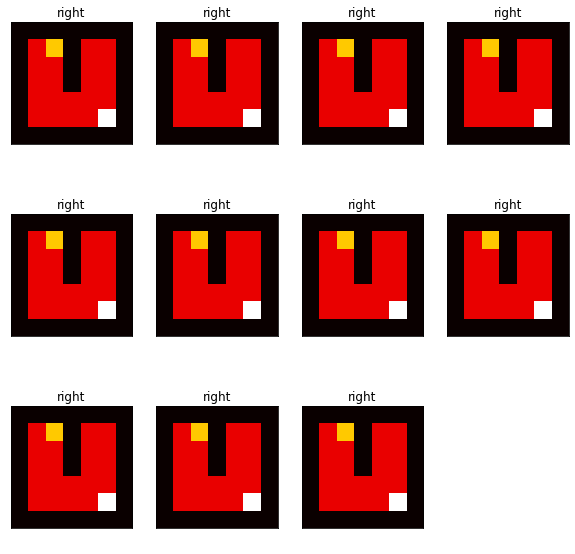

In [16]:
# INSTRUCTION 1. Explore the different parameters of the GridWorld task
grid_size_test = 5
start_test = (1, 1)
goal_test = (grid_size_test - 1, grid_size_test - 1)
obstacles_test = [(x, grid_size_test//2) for x in range(grid_size_test-2)]
max_steps_per_trial_test = 20
env = GridWorld(size=grid_size_test, start=start_test, goal=goal_test, obstacles=obstacles_test, max_steps_per_trial=max_steps_per_trial_test)
# action names
actions = ['up', 'right', 'down', 'left']
# INSTRUCTION 2. Define an action plan to reach the goal by hand (Note that the actions correspond to codes 0,1,2,3)
good_path = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
# number of rows and columns is the root of the number of actions
nrows = int(np.sqrt(len(good_path)))
ncols = nrows+1
f, ax = plt.subplots(figsize=(10, 10), nrows=nrows, ncols=ncols)
ax = ax.flatten()
for i_a, action in enumerate(good_path):
    env.step(action)
    env.render(ax=ax[i_a])
    # remove xtiks and yticks
    ax[i_a].set_xticks([])
    ax[i_a].set_yticks([])
    # add title
    ax[i_a].set_title(actions[action])
# remove last axis
ax[-1].axis('off')

### Random Agent

We will start by implementing a random agent. As you see, the random agent does not care about the environment and choses a random action from the available ones.

In [ ]:
class Random:
    """ 
    Random agent. 
    The random agent selects an action at random from the action space and does not try to learn anything (don't be like the random agent!)
    """
    def __init__(self, action_space):
        self.action_space = action_space
    # Side note: **kwargs is a dictionary of arguments that allows us to pass an arbitrary number of arguments to the function. We use it here
    # to make the function compatible with the train_agent function below.
    def get_action(self, **kwargs):
        return np.random.choice(self.action_space)
    def learn(self, **kwargs):
        pass

### Training function

This is the function we will use to train all our agents. It establishes the communication between the agent and the environment.

Think of what the gridworld needs from the agent to update the state and what the agent needs from the gridworld to act and learn to make better decisions.

In [ ]:
def train_agent(agent, grid_size=5, start=(0, 0), goal=(4, 4), obstacles=[(x, 3) for x in range(3)],
                max_num_tr=100, verbose=False, max_steps_per_trial=50):
    """
    Create gridWorld and agent, and train agent for a number of trials.

    Args:
        agent: agent to train
        grid_size: int, size of the grid
        start: tuple, starting position of the agent
        goal: tuple, goal position for the agent
        obstacles: list of tuples, positions of the obstacles
        max_num_tr: int, maximum number of trials
        verbose: bool, whether to display the environment
        max_steps_per_trial: int, maximum number of steps per trial
    """
    # Create grid world
    env = GridWorld(size=grid_size, start=start, goal=goal, obstacles=obstacles, max_steps_per_trial=max_steps_per_trial)

    # First action of the agent. In order to act the agent needs to know the state of the environment.
    action = agent.get_action(state=start)
    state, _, _ = env.step(action)
    reward_per_episode = []
    total_reward = 0
    while env.trial < max_num_tr:
        # Get the next action from the agent.
        action = agent.get_action(state=state)
        next_state, reward, info = env.step(action)
        # Learn from the experience. In order to learn the agent needs to know the previous state, the action taken, the reward obtained and the new state after the action.
        agent.learn(state=state, action=action, reward=reward, next_state=next_state)
        state = next_state
        if verbose and env.trial % 10 == 0:
            print(f"Trial: {env.trial + 1}, Step: {env.t + 1}, State: {state}, Action: {action}, Next State: {next_state},\
                    Reward: {reward}, Total Reward: {total_reward}, New trial: {info['new_trial']}")
        total_reward += reward
        if info['new_trial']: # check if the trial has ended
            reward_per_episode.append(total_reward)
            total_reward = 0
    return reward_per_episode

Streaming output truncated to the last 5000 lines.
Trial: 762, Step: 21, State: (6, 2), Action: 2, Next State: (6, 2),                    Reward: -1, Total Reward: -19, New trial: False
Trial: 763, Step: 1, State: (1, 1), Action: 0, Next State: (1, 1),                    Reward: -1, Total Reward: -20, New trial: True
Trial: 763, Step: 2, State: (2, 1), Action: 3, Next State: (2, 1),                    Reward: -1, Total Reward: 0, New trial: False
Trial: 763, Step: 3, State: (2, 1), Action: 0, Next State: (2, 1),                    Reward: -1, Total Reward: -1, New trial: False
Trial: 763, Step: 4, State: (2, 2), Action: 2, Next State: (2, 2),                    Reward: -1, Total Reward: -2, New trial: False
Trial: 763, Step: 5, State: (1, 2), Action: 1, Next State: (1, 2),                    Reward: -1, Total Reward: -3, New trial: False
Trial: 763, Step: 6, State: (0, 2), Action: 1, Next State: (0, 2),                    Reward: -1, Total Reward: -4, New trial: False
Trial: 763, Step:

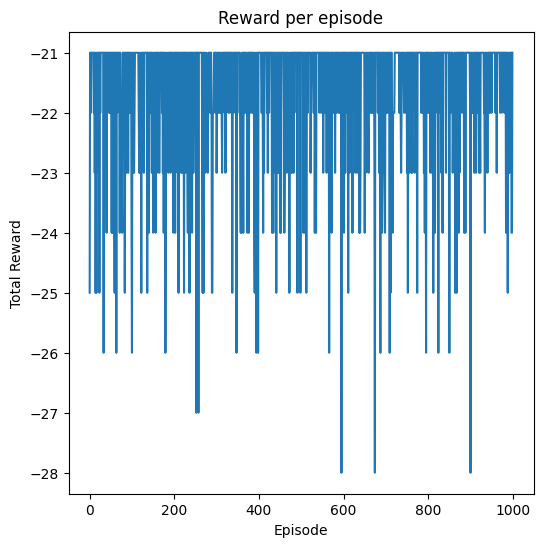

In [ ]:
action_space = [0, 1, 2, 3, 4]  # up, right, down, left  # render flag so people can see agent moving randomly
max_num_tr = 1000
verbose = True
agent = Random(action_space=action_space)
reward_per_episode_random =\
      train_agent(agent=agent, grid_size=grid_size, start=start, goal=goal,
                  obstacles=obstacles, max_num_tr=max_num_tr,
                  verbose=verbose, max_steps_per_trial=max_steps_per_trial)
plot_reward_per_episode(reward_per_episode_random)

You see there random agent does not do great, but its performance will be a good baseline for us to evaluate the learning of the rest of the agents.

### SARSA Agent

The state-action-reward-state-action (SARSA) agent uses an on-line policy to learn the best policy. The SARSA algorithm works by maintaining a table of action-value estimates Q(s, a) (the q_table), where s is the state and a is the action taken by the agent in that state.

In [ ]:
class SARSAAgent:
    def __init__(self, action_space, state_space, alpha=0.1, gamma=0.9, epsilon=1):
        self.action_space = action_space
        self.state_space = state_space
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = np.random.rand(self.state_space[0], self.state_space[1], len(self.action_space))

    # INSTRUCTION 6: return the agent's action.
    def get_action(self, state):
        # INSTRUCTION 6.1: implement epsilon-greedy policy
        if state is None or np.random.rand() < self.epsilon:  # Explore: select a random action
            return np.random.choice(self.action_space)
        else:                                # Exploit: select the action with max value (greedy policy)
            return np.argmax(self.q_table[state[0], state[1]])
    # INSTRUCTION 7: learn from experience
    def learn(self, state, action, reward, next_state):
        # INSTRUCTION 7.1: get old value from the q-table
        old_value = self.q_table[state[0], state[1], action]
        # INSTRUCTION 7.2: get action from the q-table
        next_action = self.get_action(next_state)
        # INSTRUCTION 7.3: get the maximum value from the q-table for the next state and action
        next_max = self.q_table[next_state[0], next_state[1], next_action]
        # INSTRUCTION 7.4: update the q-table
        new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max)
        self.q_table[state[0], state[1], action] = new_value
    def get_q_table(self):
        return self.q_table

Streaming output truncated to the last 5000 lines.
Trial: 638, Step: 10, State: (6, 5), Action: 2, Next State: (6, 5),                    Reward: -1, Total Reward: -8, New trial: False
Trial: 638, Step: 11, State: (6, 6), Action: 2, Next State: (6, 6),                    Reward: -1, Total Reward: -9, New trial: False
Trial: 638, Step: 12, State: (6, 7), Action: 2, Next State: (6, 7),                    Reward: -1, Total Reward: -10, New trial: False
Trial: 639, Step: 1, State: (1, 1), Action: 3, Next State: (1, 1),                    Reward: 50, Total Reward: -11, New trial: True
Trial: 639, Step: 2, State: (1, 2), Action: 2, Next State: (1, 2),                    Reward: -1, Total Reward: 0, New trial: False
Trial: 639, Step: 3, State: (1, 3), Action: 2, Next State: (1, 3),                    Reward: -1, Total Reward: -1, New trial: False
Trial: 639, Step: 4, State: (1, 2), Action: 4, Next State: (1, 2),                    Reward: -1, Total Reward: -2, New trial: False
Trial: 639, Ste

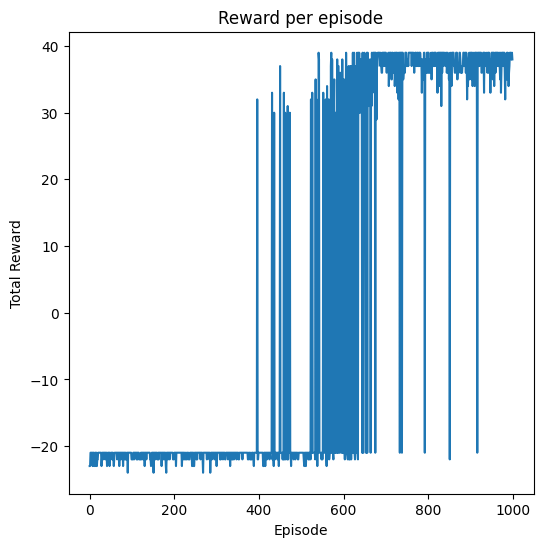

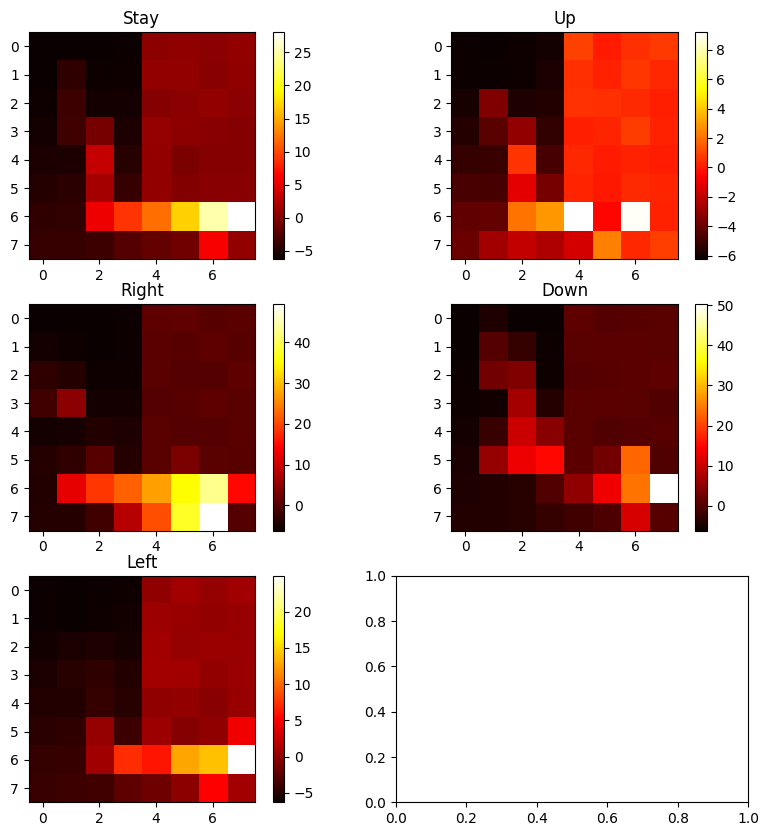

In [ ]:
state_space = (grid_size, grid_size)
epsilon = 0.1
agent = SARSAAgent(action_space=action_space, state_space=state_space, epsilon=epsilon)
reward_per_episode_sarsa =\
      train_agent(agent=agent, grid_size=grid_size, start=start, goal=goal,
                  obstacles=obstacles, max_num_tr=max_num_tr,
                  verbose=verbose, max_steps_per_trial=max_steps_per_trial)
plot_reward_per_episode(reward_per_episode_sarsa)
plot_q_table(agent, action_space)

### Q-Learning Agent

The Q-learning agent uses an off-line policy to learn about the environment. As the SARSA algorithm, it works by maintaining a table of action-value estimates Q(s, a). The difference between the two is in the way they update the q-table.

In [ ]:
class QLearningAgent:
    def __init__(self, action_space, state_space, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.action_space = action_space
        self.state_space = state_space
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = np.random.rand(self.state_space[0], self.state_space[1], len(self.action_space))
    # INSTRUCTION 8: return the agent's action.
    def get_action(self, state):
        # INSTRUCTION 8.1: implement epsilon-greedy policy
        if state is None or np.random.rand() < self.epsilon:  # Explore: select a random action
            return np.random.choice(self.action_space)
        else:                                # Exploit: select the action with max value (greedy policy)
            return np.argmax(self.q_table[state[0], state[1]])
    # INSTRUCTION 9: learn from experience
    def learn(self, state, action, reward, next_state):
        # INSTRUCTION 9.1: get old value from the q-table
        old_value = self.q_table[state[0], state[1], action]
        # INSTRUCTION 9.2: get the maximum value from the q-table for the next state and action. This is different from SARSA!
        next_max = np.max(self.q_table[next_state[0], next_state[1]])
        # INSTRUCTION 9.3: update the q-table
        new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max)
        self.q_table[state[0], state[1], action] = new_value
    def get_q_table(self):
        return self.q_table

In [ ]:
state_space = (grid_size, grid_size)
epsilon = 0.1
agent = QLearningAgent(action_space=action_space, state_space=state_space, epsilon=epsilon)

reward_per_episode_ql =\
      train_agent(agent=agent, grid_size=grid_size, start=start, goal=goal,
                  obstacles=obstacles, max_num_tr=max_num_tr,
                  verbose=verbose, max_steps_per_trial=max_steps_per_trial)
plot_reward_per_episode(reward_per_episode_ql)
plot_q_table(agent, action_space)

Trial: 1, Step: 3, State: (0, 0), Action: 4, Next State: (0, 0),                    Reward: -1, Total Reward: 0, New trial: False
Trial: 1, Step: 4, State: (0, 1), Action: 2, Next State: (0, 1),                    Reward: -1, Total Reward: -1, New trial: False
Trial: 1, Step: 5, State: (0, 0), Action: 4, Next State: (0, 0),                    Reward: -1, Total Reward: -2, New trial: False
Trial: 1, Step: 6, State: (0, 0), Action: 4, Next State: (0, 0),                    Reward: -1, Total Reward: -3, New trial: False
Trial: 1, Step: 7, State: (0, 1), Action: 2, Next State: (0, 1),                    Reward: -1, Total Reward: -4, New trial: False
Trial: 1, Step: 8, State: (0, 1), Action: 2, Next State: (0, 1),                    Reward: -2, Total Reward: -5, New trial: False
Trial: 1, Step: 9, State: (0, 0), Action: 4, Next State: (0, 0),                    Reward: -1, Total Reward: -7, New trial: False
Trial: 1, Step: 10, State: (0, 0), Action: 4, Next State: (0, 0),                   

### Q-Learning Agent with elegibility trace

In [ ]:
class QLearningAgent_with_eligibility:
    def __init__(self, action_space, state_space, alpha=0.1, gamma=0.9, epsilon=0.1, lambda_=0.9):
        self.action_space = action_space
        self.state_space = state_space
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.lambda_ = lambda_
        self.q_table = np.random.rand(self.state_space[0], self.state_space[1], len(self.action_space))
        self.eligibility_trace = np.zeros((self.state_space[0], self.state_space[1]))
    # INSTRUCTION 10: return the agent's action.
    def get_action(self, state):
        if state is None or np.random.rand() < self.epsilon:  # Explore: select a random action
            return np.random.choice(self.action_space)
        else:  # Exploit: select the action with max value (greedy policy)
            return np.argmax(self.q_table[state[0], state[1]])
    # INSTRUCTION 11: learn from experience
    def learn(self, state, action, reward, next_state):
        # INSTRUCTION 11.1: get old value from the q-table
        old_value = self.q_table[state[0], state[1], action]
        # INSTRUCTION 11.2: update eligibility trace
        self.eligibility_trace *= self.gamma * self.lambda_
        # INSTRUCTION 11.3: update eligibility trace for the current state and action
        self.eligibility_trace[state[0], state[1]] += 1
        # INSTRUCTION 11.4: get the maximum value from the q-table for the next state and action
        next_max = np.max(self.q_table[next_state[0], next_state[1]])

        # INSTRUCTION 11.5: calculate the temporal difference delta
        delta = reward + self.gamma * next_max - old_value

        # INSRTUCTION 11.6: Update Q-value using eligibility trace
        self.q_table[state[0], state[1], action] += self.alpha * delta * self.eligibility_trace[state[0], state[1]]
    def get_q_table(self):
        return self.q_table


In [ ]:
state_space = (grid_size, grid_size)
epsilon = 0.1
alpha = 0.1
gamma = 0.9
lambda_= 0.9
agent = QLearningAgent_with_eligibility(action_space=action_space, state_space=state_space, epsilon=epsilon,
                                        alpha=alpha, gamma=gamma, lambda_=lambda_)
reward_per_episode_et =\
      train_agent(agent=agent, grid_size=grid_size, start=start, goal=goal,
                  obstacles=obstacles, max_num_tr=max_num_tr,
                  verbose=verbose, max_steps_per_trial=max_steps_per_trial)
plot_reward_per_episode(reward_per_episode_et)
plot_q_table(agent, action_space)

### Compare learning

In [ ]:
# create figure
f, ax = plt.subplots(figsize=(6, 6))
plot_reward_per_episode(reward_per_episode_random, ax=ax)
plot_reward_per_episode(reward_per_episode_sarsa, ax=ax)
plot_reward_per_episode(reward_per_episode_ql, ax=ax)
plot_reward_per_episode(reward_per_episode_et, ax=ax)
# add legend to ax
ax.legend(['Random', 'SARSA', 'Q-Learning', 'Q-Learning with Eligibility Trace'])
ax.set_title("Reward per episode")
ax.set_xlabel("Episode")
ax.set_ylabel("Total Reward")

